# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

In [2]:
# This line below loads the Unity environment file.
# -------------------------------------------------
# If you would to run this code, please consult the README to find out whether you need or don't need
# to change this line.
env = UnityEnvironment(file_name="Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Let's build some code and let's feed it with some banana

In the cells below I'll solve the navigation project. If you're interested in playing around with the environment please open and run `Navigation_Original.ipynb` from this directory.

I decided to keep all of my code in one single file here. However this practice isn't really common in everyday practice because of the reusability of the code parts in this case I find it better since the goal of this project is to present my solution and let others to play around with. Putting all the code here increases the user experience - or at least I hope so. 😃

#### 3.1. Importing modules & detecting local opportunities

The availability of CUDA speeds up the process very well.

In [5]:
import pandas as pd
import random
import torch
from torch import nn, optim
from collections import deque, namedtuple
import matplotlib.pyplot as plt

%matplotlib inline

device = "cuda" if torch.cuda.is_available() else "cpu"
print('Training on {}.'.format(device))

Training on cuda.


#### 3.2. Setting up the parameters

Here are the most important parameters to perform a likely successful training. You can play around with it, the basic values are listed here if you want to reset them.

In [6]:
BUFFER_SIZE = int(1e5)  # Size of the replay buffer
BATCH_SIZE = 64         # Size of minibatches
GAMMA = 0.99            # The discount factor
LR = 5e-4               # Learning rate 
TAU = 1e-3              # Fixed value for soft update of the target parameters
UPDATE_AT = 4           # Specifies often to update the network

#### 3.3. Helper functions

In [7]:
def deep_q_train(agent, save_to, episodes_count=2000, maxtimesteps=1000, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995):
    """
    Performs Deep Q-Learning.
    -------------------------
    @Params:	agent			(Agent)		Agent to work with.
                save_to			(string)	Name of the file to save model
                maxtimesteps	(int)		Maximum count of timesteps in an episode.
                epsilon_start	(float)		Beginning value of epsilon.
                epsilon_end		(float)		End value of epsilon.
                epsilon_decay	(float)		Multiplier to decrease epsilon after every episode.
    """
    global brain_name
    global env
    global env_info
    
    scores = []
    scores_last_100 = deque(maxlen=100)
    epsilon = epsilon_start
    
    # The value of episode is more human like this way since it changes from 1...x instead of 0...x-1 and
    # shows the number of the actual episode just like humans understand more.
    for episode in range(1, episodes_count + 1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        # In this functuin we should have at least one machine friendly for loop as well. :-)
        for timestep in range(maxtimesteps):
            action = agent.act(state, epsilon)
            env_info = env.step(action.astype(int))[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_last_100.append(score)
        scores.append(score)
        epsilon = max(epsilon_end, epsilon_decay * epsilon)
        
        print('\rEpisode {:4d} finished, average of last 100 scores is {:.2f}. '.format(episode, np.mean(scores_last_100)), end="")
        
        # Preserve some output as on-screen log.
        if episode % 100 == 0:
            print('\rEpisode {:4d} finished, average of last 100 scores is {:.2f}. '.format(episode, np.mean(scores_last_100)))
        if np.mean(scores_last_100) >= 13.0:
            print('\n\nTraining finished.');
            print('Environment solved in pisode {:4d}, average of last 100 scores is {:.2f}.'.format(episode, np.mean(scores_last_100)))
            torch.save(agent.net_local.state_dict(), save_to)
            break
    return scores



def drawresults(scores, save_to=None):
    """
    Draws and saves scores.
    -----------------------
    @Params:	scores	(list like)	Scores to display.
                save_to	(string)	[optional] File name to save figure if given.
    """
    fig, ax = plt.subplots(1, 1, figsize=[10, 5])
    plt.rcParams.update({'font.size': 16})
    scores_rolling = pd.Series(scores).rolling(100).mean()
    ax.plot(scores)
    ax.plot(scores_rolling, c="green", linewidth=3)
    ax.set_xlabel("Episodes")
    ax.set_ylabel("Score")
    ax.grid(which="major")
    ax.axhline(13, c="red", linewidth=3)
    ax.legend(["Scores of episodes", "Average of last 100 episodes", "Target score=13"])
    
    if save_to != None:
        fig.savefig(save_to)

#### 3.4. The model

In [8]:
class BananaQNetwork(nn.Module):
    """
    This class represents an Actor (Policy) Model. It inherts from PyTorch NN Module.
    __init__() and forward() are overwritten only.
    """



    def __init__(self, state_size, action_size, seed, h1_size=64, h2_size=64, is_dueling=False):
        """
        Initializes the class.
        ----------------------
        @Params:	state_size	(int)		Count of state's dimensions.
                    action_size	(int)		Count of action's dimensions.
                    seed		(int)		Rendom seed.
                    h1_size		(int)		[optional] Count of nodes in the 1st hidden layer.
                    h2_size		(int)		[optional] Count of nodes in the 2nd hidden layer.
                    is_dueling	(boolean)	[optional] Whether to create a dueling network or not.
        """
        super(BananaQNetwork, self).__init__()
        
        torch.manual_seed(seed)
        self.__is_dueling = is_dueling
        
        self.fc1 = nn.Linear(state_size, h1_size)
        self.fc2 = nn.Linear(h1_size, h2_size)
        self.fc3 = nn.Linear(h2_size, action_size)
        
        if self.__is_dueling:
            self.state_value = nn.Linear(h2_size, 1)



    def forward(self, x):
        """
        Fordwards the input (state) through the whole network and returns the network's output.
        ---------------------------------------------------------------------------------------
        @Params:	x	(torch.Tensor)	Input data (state).
        @Return:	(torch.Tensor)		The output of the network (advantage values).
                    (torch.Tensor)		The state value (if is_dueling is True).
        """
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        if self.__is_dueling:
            return self.fc3(x) + self.state_value(x)
        else:
            return self.fc3(x)

#### 3.6. The replay buffer

In [9]:
class ReplayBuffer(object):
    """
    This class represents the experience of the agent.
    This class doesn't really have any superclass aside of object which is the top most superclass usually.
    """



    def __init__(self, action_size, buffer_size, batch_size, seed):
        """
        Initializes the class.
        ----------------------
        @Params:	action_size	(int)	Count of action's dimensions.
                    buffer_size	(int)	Size of the actual buffer.
                    batch_size	(int)	Size of training batches.
                    seed		(int)	Rendom seed.
        """
        random.seed(seed)
        
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])



    def add(self, state, action, reward, next_state, done):
        """
        Adds a new experience to the memory.
        ------------------------------------
        @Params:	state		(float)	Current state.
                    action		(long)	Taken action.
                    reward		(float)	Received reward.
                    next_state	(float)	Next state (resulting state).
                    done		(float)	Whether it's finished or not.
        """
        new_experience = self.experience(state, action, reward, next_state, done)
        self.memory.append(new_experience)



    def sample(self):
        """
        Samples random batches from the memory.
        ---------------------------------------
        @Return:	(tuple)	Batch
        """
        global device
        
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([x.state for x in experiences if x is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([x.action for x in experiences if x is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([x.reward for x in experiences if x is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([x.next_state for x in experiences if x is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([x.done for x in experiences if x is not None]).astype(np.uint8)).float().to(device)
        
        return (states, actions, rewards, next_states, dones)



    def __len__(self):
        """
        Returns the size of the buffer's memory and ensures the compatibility with the len() function.
        """
        return len(self.memory)

#### 3.6. The Agent

In [10]:
class Agent(object):
    """
    This class represents an agent who inteacts with the environment and can learn from it.
    This class doesn't really have any superclass aside of object which is the top most superclass usually.
    """



    def __init__(self, state_size, action_size, seed, use_double_dqn=True):
        """
        Initializes the class.
        ----------------------
        @Params:	state_size		(int)		Count of state's dimensions.
                    action_size		(int)		Count of action's dimensions.
                    seed			(int)		Rendom seed.
                    use_double_dqn	(boolean)	[optional] Whether to use duoble DQN or not.
        """
        global BATCH_SIZE
        global BUFFER_SIZE
        global LR
        
        global device
        
        random.seed(seed)
        
        self.state_size = state_size
        self.action_size = action_size
        self.use_double_dqn = use_double_dqn
        
        self.net_local = BananaQNetwork(state_size, action_size, seed).to(device)
        self.net_target = BananaQNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.net_local.parameters(), lr=LR)
        
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        
        self.__timestep = 0



    def act(self, state, epsilon=0.0):
        """
        Selects action for given state according to the given epsilon.
        --------------------------------------------------------------
        @Params:	state	(array like)	Current state.
                    epsilon	(float)			Value of likelihood for epsilon-greedy policy.
        @Return:	(long)					Selected action.
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        
        self.net_local.eval()
        with torch.no_grad():
            action_values = self.net_local(state)
        self.net_local.train()
        
        if random.random() > epsilon:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))



    def learn(self, experiences, gamma):
        """
        Performs experience based update of parameters.
        -----------------------------------------------
        @Params:	experience	(tuple)	Experiences to work with.
                    gamma		(float)	
        """
        global TAU
        
        states, actions, rewards, next_states, dones = experiences
        
        if self.use_double_dqn:
            local_next_states_q = self.net_local(next_states).detach()
            local_best_actions = local_next_states_q.max(1)[1]
            target_next_states_q = self.net_target(next_states).detach()
            targets_next = target_next_states_q.gather(1, local_best_actions.unsqueeze(1))
        else:
            targets_next = self.net_target(next_states).detach().max(1)[0].unsqueeze(1)
        
        q_targets = rewards + (gamma * targets_next * (1 - dones))
        q_expected = self.net_local(states).gather(1, actions)
        
        loss = nn.functional.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.soft_update(self.net_local, self.net_target, TAU)



    def soft_update(self, src_model, dest_model, tau):
        """
        Performs soft update on model parameters.
        -----------------------------------------
        @Params:	src_model	(nn.Module)	Model to copy weights from.
                    dest_model	(nn.Module)	Model to copy weights to.
                    taz			(float)		Parameter of interpolation.
        """
        for src_param, dest_param in zip(src_model.parameters(), dest_model.parameters()):
            dest_param.data.copy_(tau * src_param.data + (1.0 - tau) * dest_param.data)



    def step(self, state, action, reward, next_state, done):
        """
        Takes a step in the action-space and calls learning if needed.
        --------------------------------------------------------------
        @Params:	state		(float)	Current state.
                    action		(long)	Taken action.
                    reward		(float)	Received reward.
                    next_state	(float)	Next state (resulting state).
                    done		(float)	Whether it's finished or not.
        """
        global BATCH_SIZE
        global GAMMA
        global UPDATE_AT
        
        self.memory.add(state, action, reward, next_state, done)
        
        # This is a tricky way to calculate timesteps but there are 2 good reasons to do so:
        # 1. Increasing before evaluation avoids from learning rith at the 1st step.
        # 2. Taking the modulo as a new value is just fine since we aren't curious about the real count of steps.
        self.__timestep = (self.__timestep + 1) % UPDATE_AT
        
        # This is the case where two ifs are more optimal than one since in case of 
        # "if self.__timestamp == 0 and len(self.memory) > BATCH_SIZE"
        # the requirement "len(self.memory) > BATCH_SIZE" would calculated UPDATE_AT times
        # more with the one-line "if" since both sides of "and" is evaluated. :D
        if self.__timestep == 0:
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

#### 3.7. Let's see those bananas finally...
Two instances of agents will be trained.

In [11]:
agent_sinple = Agent(state_size=state_size, action_size=action_size, seed=0, use_double_dqn=False)
agent_double = Agent(state_size=state_size, action_size=action_size, seed=0, use_double_dqn=True)

##### 3.7.1. Train simple agent

In [12]:
scores_simple = deep_q_train(agent=agent_sinple, save_to='./agent_simple.pth')

Episode  100 finished, average of last 100 scores is 0.70.  
Episode  200 finished, average of last 100 scores is 4.21. 
Episode  300 finished, average of last 100 scores is 7.23. 
Episode  400 finished, average of last 100 scores is 10.90. 
Episode  500 finished, average of last 100 scores is 12.73. 
Episode  524 finished, average of last 100 scores is 13.06. 

Training finished.
Environment solved in pisode  524, average of last 100 scores is 13.06.


##### 3.7.2. Show and save results of simple agent

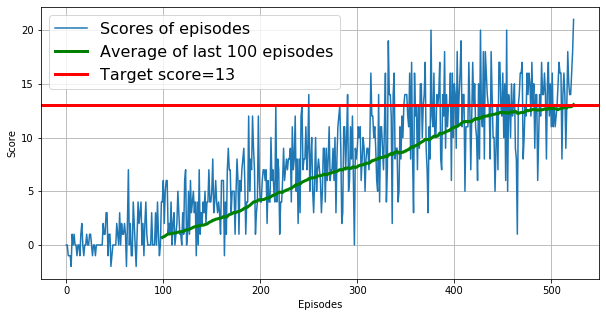

In [13]:
drawresults(scores_simple, './scores_simple.jpg')

##### 3.7.3. Train simple agent

In [14]:
scores_double = deep_q_train(agent=agent_double, save_to='./agent_double.pth')

Episode  100 finished, average of last 100 scores is 0.57.  
Episode  200 finished, average of last 100 scores is 4.43. 
Episode  300 finished, average of last 100 scores is 7.46. 
Episode  400 finished, average of last 100 scores is 11.03. 
Episode  453 finished, average of last 100 scores is 13.03. 

Training finished.
Environment solved in pisode  453, average of last 100 scores is 13.03.


##### 3.7.4. Show and save results of double agent

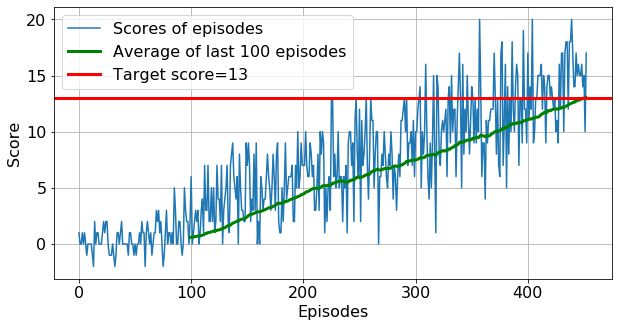

In [15]:
drawresults(scores_double, './scores_double.jpg')

#### 3.8. Let's test our agent

Our well educated agent should perform better than the average performance of the last 100 episodes. At least I hope so.

In [18]:
agent_double.net_local.load_state_dict(torch.load('./agent_double.pth'))
env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]
score = 0
# Let's assume the evironment aint finished at the beginning. :D
done = False
while not done:
    action = agent_double.act(state, epsilon=0.0)
    env_info = env.step(action.astype(int))[brain_name]
    next_state = env_info.vector_observations[0]
    reward = env_info.rewards[0]
    done = env_info.local_done[0]
    score += reward
    state = next_state
print('A well educated agent achieves score of {}'.format(score))

A well educated agent achieves score of 20.0


#### 3.9. The end

The environment should be closed now.

In [19]:
env.close()